In [0]:
import time
import h5py
import warnings
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow
import tensorflow.keras.backend as K

from google.colab import drive
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam

sns.set(style="whitegrid")
warnings.filterwarnings("ignore")
drive.mount('/content/drive/')
print (tensorflow.test.gpu_device_name())

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/device:GPU:0


# **Data Preprocessing**

**Data Preview**

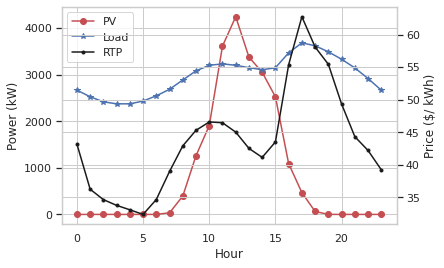

In [0]:
df_raw = pd.read_csv("/content/drive/My Drive/Colab/Research - EE5003/Final Modified Data_Rev2.csv")
df = df_raw.copy()
df = df.iloc[:,1:]

fig, ax = plt.subplots(1, 1)
ax2 = ax.twinx()

PV_plot = ax.plot(df.iloc[0:24, 0], 'ro-', label = "PV")
load_plot = ax.plot(df.iloc[0:24, 1], 'b*-', label = "Load")
price_plot = ax2.plot(df.iloc[0:24, 2], 'k.-', label = "RTP")

# Show all label in one box
plots = PV_plot + load_plot + price_plot
labels = [plot.get_label() for plot in plots]
ax.legend(plots, labels, loc = 0)

ax.set_xlabel("Hour")
ax.set_ylabel("Power (kW)")
ax2.set_ylabel("Price ($/ kWh)")

plt.show()

**Standardization**

In [0]:
# MinMaxScaler

# The mean is not shifted to zero-centered
sc_price = StandardScaler(with_mean = False)
price = sc_price.fit_transform(df.iloc[:, 2:].values)

sc_energy = StandardScaler(with_mean = False)
pv = sc_energy.fit_transform(df.iloc[:, 0:1].values)
load = sc_energy.transform(df.iloc[:, 1:2].values)

x = np.concatenate([pv, load, price], axis = -1)

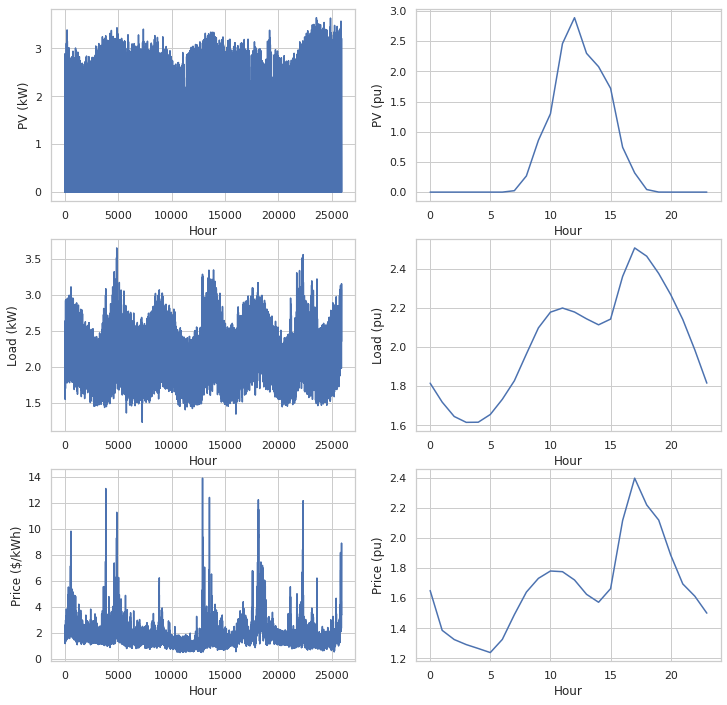

In [0]:
fig, ax = plt.subplots(3, 2, figsize = (12, 12))

ax[0, 0].plot(x[:, 0])
ax[0, 0].set_xlabel("Hour")
ax[0, 0].set_ylabel("PV (kW)")

ax[0, 1].plot(x[0:24, 0])
ax[0, 1].set_xlabel("Hour")
ax[0, 1].set_ylabel("PV (pu)")

ax[1, 0].plot(x[:, 1])
ax[1, 0].set_xlabel("Hour")
ax[1, 0].set_ylabel("Load (kW)")

ax[1, 1].plot(x[0:24, 1])
ax[1, 1].set_xlabel("Hour")
ax[1, 1].set_ylabel("Load (pu)")

ax[2, 0].plot(x[:, 2])
ax[2, 0].set_xlabel("Hour")
ax[2, 0].set_ylabel("Price ($/kWh)")

ax[2, 1].plot(x[0:24, 2])
ax[2, 1].set_xlabel("Hour")
ax[2, 1].set_ylabel("Price (pu)")
plt.show()

# **Model**

**Deep Q-Network Model**

In [0]:
class DQNNet():
  def __init__(self, state_size, action_size, learning_rate):
    self.state_size = state_size
    self.action_size = action_size
    self.learning_rate = learning_rate
    self.model = self.create_model()
    
  def create_model(self):
    input = Input(shape = (self.state_size, ))
    x = Dense(40, activation = "elu", 
              kernel_initializer = glorot_uniform(seed = 42))(input)
    x = Dense(160, activation = "elu",
              kernel_initializer = glorot_uniform(seed = 42))(x)
    output = Dense(self.action_size, activation = "linear", 
              kernel_initializer = glorot_uniform(seed = 42))(x)
    model = Model(inputs = [input], outputs = [output])
    model.compile(loss = "mse", optimizer = Adam(lr = self.learning_rate))
    model.summary()
    return model

**Memory Model**

In [0]:
# A tree based array containing priority of each experience for fast sampling

class SumTree():
  
  """
  __init__ - create data array storing experience and a tree based array storing priority
  add - store new experience in data array and update tree with new priority
  update - update tree and propagate the change through the tree
  get_leaf - find the final nodes with a given priority value
  """

  data_pointer = 0

  def __init__(self, capacity):
    
    """
    capacity - Number of final nodes containing experience
    data - array containing experience (with pointers to Python objects)
    tree - a tree shape array containing priority of each experience

     tree:
        0
       / \
      0   0
     / \ / \
    0  0 0  0 
    """
    self.capacity = capacity
    self.data = np.zeros(capacity, dtype = object)
    self.tree = np.zeros(2 * capacity - 1)

  def add(self, priority, data):
    
    # Start from first leaf node of the most bottom layer
    tree_index = self.data_pointer + self.capacity - 1

    self.data[self.data_pointer] = data # Update data frame
    self.update(tree_index, priority) # Update priority

    # Overwrite if exceed memory capacity
    self.data_pointer += 1
    if self.data_pointer >= self.capacity:  
      self.data_pointer = 0

  def update(self, tree_index, priority):

    # Change = new priority score - former priority score
    change = priority - self.tree[tree_index] 
    self.tree[tree_index] = priority

    # Propagate the change through tree
    while tree_index != 0: 
      tree_index = (tree_index - 1) // 2
      self.tree[tree_index] += change

  def get_leaf(self, v):

    parent_index = 0

    while True:
      left_child_index = 2 * parent_index + 1
      right_child_index = left_child_index + 1
      # Downward search, always search for a higher priority node till the last layer
      if left_child_index >= len(self.tree):
        leaf_index = parent_index
        break
      else: 
        if v <= self.tree[left_child_index]:
          parent_index = left_child_index
        else:
          v -= self.tree[left_child_index]
          parent_index = right_child_index

    data_index = leaf_index - self.capacity + 1
      
    # tree leaf index, priority, experience
    return leaf_index, self.tree[leaf_index], self.data[data_index]

In [0]:
class Memory():  # stored as (s, a, r, s_) in SumTree
    
  """
  
  __init__ - create SumTree memory
  store - assign priority to new experience and store with SumTree.add & SumTree.update
  sample - uniformly sample from the range between 0 and total priority and 
           retrieve the leaf index, priority and experience with SumTree.get_leaf
  batch_update - update the priority of experience after training with SumTree.update
  
  PER_e - Hyperparameter that avoid experiences having 0 probability of being taken
  PER_a - Hyperparameter that allows tradeoff between taking only experience with 
          high priority and sampling randomly (0 - pure uniform randomness, 1 -
          select experiences with the highest priority)
  PER_b - Importance-sampling, from initial value increasing to 1, control how much
          IS affect learning
          
  """
  
  PER_e = 0.01 
  PER_a = 0.6
  PER_b = 0.4
  PER_b_increment_per_sampling = 0.01
  absolute_error_upper = 1.  # Clipped abs error

  def __init__(self, capacity):
    
    self.tree = SumTree(capacity)

  def store(self, experience):
    
    # Find the max priority
    max_priority = np.max(self.tree.tree[-self.tree.capacity:])

    # If the max priority = 0, this experience will never have a chance to be selected
    # So a minimum priority is assigned
    if max_priority == 0:
      max_priority = self.absolute_error_upper

    self.tree.add(max_priority, experience)

  def sample(self, n):

    """
    First, to sample a minibatch of k size, the range [0, priority_total] is
    divided into k ranges. A value is uniformly sampled from each range. Search 
    in the sumtree, the experience where priority score correspond to sample 
    values are retrieved from. Calculate IS weights for each minibatch element
    """

    b_memory = []
    b_idx = np.empty((n, ))
    b_ISWeights =  np.empty((n, 1))

    priority_segment = self.tree.tree[0] / n   

    self.PER_b = np.min([1., self.PER_b + self.PER_b_increment_per_sampling])

    prob_min = np.min(self.tree.tree[-self.tree.capacity:]) / self.tree.tree[0]
    max_weight = (prob_min * n) ** (-self.PER_b)

    for i in range(n):
      a = priority_segment * i
      b = priority_segment * (i + 1)
      value = np.random.uniform(a, b)
      index, priority, data = self.tree.get_leaf(value)
      prob = priority / self.tree.tree[0]
      b_ISWeights[i, 0] = (prob * n) ** (-self.PER_b) / max_weight               
      b_idx[i]= index
      b_memory.append([data])

    return b_idx, b_memory, b_ISWeights

  def batch_update(self, tree_idx, abs_errors):
      
    # To avoid 0 probability
    abs_errors += self.PER_e 
    clipped_errors = np.minimum(abs_errors, self.absolute_error_upper)
    ps = np.power(clipped_errors, self.PER_a)

    for ti, p in zip(tree_idx, ps):
      self.tree.update(ti, p)

**Battery Model**

In [0]:
class Battery():
    
  def __init__(self, action_size, scaler_energy, scaler_price):
    """
    P_rated - charge/ discharge rate (kW)
    E_rated - rated capacity (kWh)
    C_E - energy capital cost ($/kWh)
    LC - life cycle
    eta - efficiency
    DOD - depth of discharge
    wear_cost - wear & operation cost ($/kWh/operation)
    wear_cost = (C_E * E_rated) / (eta * E_rated * LC * DOD)
    a1, m1, m2_c, m2_d: multiplier for energy gain
    """ 
    self.P_rated = scaler_energy.transform(np.array([[1000]]))[0] # pu
    self.E_rated = scaler_energy.transform(np.array([[5000]]))[0] # pu 
    self.C_E = scaler_price.transform(np.array([[171]]))[0] # pu
    self.LC = 4996
    self.eta = 1.
    self.DOD = 1.
    self.wear_cost = self.C_E / self.eta / self.DOD / self.LC
    self.action_set = np.linspace(-1, 1, num = action_size, endpoint = True)
    self.initial_SOC = 0.
    self.target_SOC = 0.5 # Decide the backup energy required
    self.a1 = 4.
    self.m1 = 2
    self.m2_c = 0.9
    self.m2_d = 1.2
    self.m2_d2 = 1
    self.plot_multiplier()
    
  def compute(self, state, action):
    current_pv = state[0]
    current_load = state[1]
    current_price = state[2]
    current_SOC = state[3]
    average_price = state[4]
    
    # Update SOC level
    # Assign penalty if battery operates exceeding permissible limit
    delta_SOC = self.action_set[action] * self.P_rated / self.E_rated
    penalty = 0
    if self.action_set[action] <= 0:
      next_SOC = np.maximum(0., current_SOC + delta_SOC)
      if abs(delta_SOC) > current_SOC:
        penalty = 10
    else:
      next_SOC = np.minimum(1., current_SOC + delta_SOC)
      if abs(delta_SOC) > 1 - current_SOC:
        penalty = 10
    
    # Assign penalty to force containment of PV within the building
    penalty_pv = 0
    if current_pv > (current_load + (next_SOC - current_SOC) * self.E_rated):
      if next_SOC != 1:        
        penalty_pv = np.exp(2.5 * (1 - next_SOC)) - 1

    # Compute piecewise multiplier
    if next_SOC < self.target_SOC: # Before target SOC is met
      multiplier = 1 + self.a1 * np.exp(-(-np.log((self.m1 - 1) / self.a1)) * \
                                         next_SOC / self.target_SOC)      
    else: # After target SOC is met
      if delta_SOC >= 0: # Charge
        multiplier = np.exp(-(-np.log(self.m2_c)) * (next_SOC - self.target_SOC) \
                            / (1 - self.target_SOC))       
      else: # Discharge
        multiplier = self.m2_d * np.exp(-(-np.log(self.m2_d2 / self.m2_d)) * \
                                        (next_SOC - self.target_SOC) \
                                        / (1 - self.target_SOC))             
    
    # +ve - positive reward/ gain
    energy_gain = average_price * (next_SOC - current_SOC) * self.E_rated * multiplier
    trading_cost = current_price * (next_SOC - current_SOC) * self.E_rated
    wear_cost = self.wear_cost * np.abs((next_SOC - current_SOC) * self.E_rated)
    reward = energy_gain - trading_cost - wear_cost - penalty - penalty_pv
    
    return next_SOC, reward
  
  
  def plot_multiplier(self):
    SOC = np.linspace(0, 1, 100)
    multiplier_c = []
    multiplier_d = []
     
    # Compute piecewise multiplier
    for i in range(len(SOC)):
      if SOC[i] < self.target_SOC: # Before target SOC is met
        multiplier = 1 + self.a1 * np.exp(-(-np.log((self.m1 - 1) / self.a1)) * \
                                           SOC[i] / self.target_SOC)      
        multiplier_c.append(multiplier)
        multiplier_d.append(multiplier)
      else: # After target SOC is met
        multiplier = np.exp(-(-np.log(self.m2_c)) * (SOC[i] - self.target_SOC) \
                            / (1 - self.target_SOC))
        multiplier_c.append(multiplier)
        
        multiplier = self.m2_d * np.exp(-(-np.log(self.m2_d2 / self.m2_d)) * \
                                        (SOC[i] - self.target_SOC) \
                                        / (1 - self.target_SOC))
        multiplier_d.append(multiplier)
    
    plt.plot(SOC, np.array(multiplier_c), "r-", label = "Charge")
    plt.plot(SOC, np.array(multiplier_d), "b-", label = "Discharge")
    
    plt.axvline(x  = self.target_SOC, linestyle = "--")
    plt.axhline(y  = self.m1, linestyle = "--")
    plt.axhline(y  = self.m2_d, linestyle = "--")
    plt.axhline(y  = self.m2_d2, linestyle = "--")
    plt.axhline(y  = self.m2_c, linestyle = "--")
    #plt.annotate("({}, {:.4f})".format(target_SOC, float(cum_prob_target)), 
    #         xy=(target_SOC - 0.25, cum_prob_target + 0.08))
    
    plt.xlabel("SOC")
    plt.ylabel("Multiplier")
    plt.legend()
    plt.show()

# **Training**

**Hyperparameters Setting**

In [0]:
# DQN hyperparameters
state_size = 5 # PV, load, RTP, past 24 hour average RTP, SOC
action_size = 11
learning_rate = 0.001

# Training hyperparameters
episodes = 5
batch_size = 64    
timesteps = 24

# Exploration hyperparameters for epsilon greedy strategy
explore_start = 1.0 # exploration probability at start
explore_stop = 0.01 # minimum exploration probability 
decay_rate = 0.0001 # exponential decay rate for exploration prob

# Q-learning hyperparameters
gamma = 0.95 # Discounting rate of future reward

# Memory hyperparameters
pretrain_length = 10000 # # of experiences stored in Memory during initialization
memory_size = 10000 # # of experiences Memory can keep

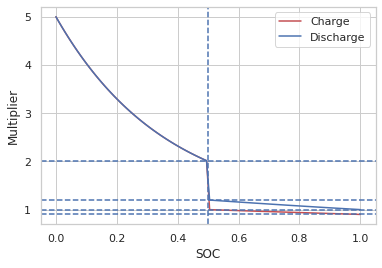

In [0]:
# Create battery model for real time SOC update and computation of cost
battery = Battery(action_size = action_size, 
                  scaler_energy = sc_energy, 
                  scaler_price = sc_price)

In [0]:
# Create memory model for priority experience replay
memory = Memory(memory_size)

In [0]:
# Create reinforcement learning model to guide the energy trading action
DQN = DQNNet(state_size = state_size, action_size = action_size, 
             learning_rate = learning_rate)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
dense (Dense)                (None, 40)                240       
_________________________________________________________________
dense_1 (Dense)              (None, 160)               6560      
_________________________________________________________________
dense_2 (Dense)              (None, 11)                1771      
Total params: 8,571
Trainable params: 8,571
Non-trainable params: 0
_________________________________________________________________


**Memory Initialization**

In [0]:
np.random.seed(42)

# Memory initialization
SOC = np.array([battery.initial_SOC])
historical_price = np.zeros(timesteps)
day = 0
hour = 0
timestep = 0
done = False

for i in range(pretrain_length):
  
  # Keep track of the past 24 hours' electricity price
  historical_price[timestep] = x[day * 24 + hour, 2]
  average_price = np.mean(np.array([price for price in historical_price if price != 0]))
  
  state = np.concatenate((x[day * 24 + hour, :], SOC, np.array([average_price])), axis = -1)
  action = np.random.randint(0, action_size)
  
  # Compute the reward and new state based on the selected action
  next_SOC, reward = battery.compute(state, action)
  
  # Store the experience in memory
  if hour < 23:
    hour += 1
    timestep += 1
    if timestep >= timesteps:
      timestep = 0
    historical_price[timestep] = x[day * 24 + hour, 2]
    average_price = np.mean(np.array([price for price in historical_price if price != 0]))
    next_state = np.concatenate((x[day * 24 + hour, :], next_SOC, np.array([average_price])), axis = -1)
  else:
    done = True
    day += 1
    hour = 0
    timestep += 1
    if timestep >= timesteps:
      timestep = 0  
    if day < len(x) / 24:
      historical_price[timestep] = x[day * 24 + hour, 2]
      average_price = np.mean(np.array([price for price in historical_price if price != 0]))
      next_state = np.concatenate((x[day * 24 + hour, :], next_SOC, np.array([average_price])), axis = -1)
    else:
      break
      
  SOC = next_SOC
  experience = state, action, reward, next_state, done
  memory.store(experience) 

**DQN Training**

In [0]:
directory = "/content/drive/My Drive/Colab/Research - EE5003/Reinforcement Learning Model_risk_averse"

In [0]:
decay_step = 0 # Decay rate for ϵ-greedy policy
total_reward_bef = -10e8
total_reward_list = []

for e in range(0, episodes, 1):

  print ("Episode {} starts".format(e))
  start_time = time.time()
  total_reward = 0
  SOC = np.array([battery.initial_SOC])
  historical_price = np.zeros(timesteps)
  day = 0
  hour = 0
  timestep = 0
  done = False

  while day < len(x) / 24:

    # Keep track of the past 24 hours' electricity price
    historical_price[timestep] = x[day * 24 + hour, 2]
    average_price = np.mean(np.array([price for price in historical_price if price != 0]))

    state = np.concatenate((x[day * 24 + hour, :], SOC, np.array([average_price])), axis = -1)

    # ϵ-greedy policy        
    exp_exp_tradeoff = np.random.rand()
    explore_probability = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * decay_step)
    # Exploration - select actions other than the currently known best action
    if (explore_probability > exp_exp_tradeoff):
      #action = np.random.randint(0, action_size)
      action_idx = np.random.randint(0, action_size-1)
      all_action = np.arange(0, action_size)
      known_best_action = np.argmax(DQN.model.predict(np.expand_dims(state, axis = 0)))
      action = all_action[all_action != known_best_action][action_idx]
    # Exploitation - select the best known action
    else:
      action = np.argmax(DQN.model.predict(np.expand_dims(state, axis = 0)))

    # Compute the reward and new state based on the selected action
    next_SOC, reward = battery.compute(state, action)  
    total_reward += reward

    # Store the experience in memory
    if hour < 23:
      hour += 1
      timestep += 1
      if timestep >= timesteps:
        timestep = 0
      historical_price[timestep] = x[day * 24 + hour, 2]
      average_price = np.mean(np.array([price for price in historical_price if price != 0]))
      next_state = np.concatenate((x[day * 24 + hour, :], next_SOC, np.array([average_price])), axis = -1)
    else:
      done = True
      day += 1
      hour = 0
      timestep += 1
      if timestep >= timesteps:
        timestep = 0
      if day < len(x) / 24:
        historical_price[timestep] = x[day * 24 + hour, 2]
        average_price = np.mean(np.array([price for price in historical_price if price != 0]))
        next_state = np.concatenate((x[day * 24 + hour, :], next_SOC, np.array([average_price])), axis = -1)
      else:
        break

    SOC = next_SOC 
    experience = state, action, reward, next_state, done
    memory.store(experience)
    decay_step +=1

    # DQN training            
    tree_idx, batch, ISWeights_mb = memory.sample(batch_size) # Obtain random mini-batch from memory

    states_mb = np.array([each[0][0] for each in batch])
    actions_mb = np.array([each[0][1] for each in batch])
    rewards_mb = np.array([each[0][2] for each in batch]) 
    next_states_mb = np.array([each[0][3] for each in batch])
    dones_mb = np.array([each[0][4] for each in batch])

    targets_mb = DQN.model.predict(states_mb)

    # Update those targets at which actions are taken
    target_batch = []
    q_next_state = DQN.model.predict(next_states_mb)
    for i in range(0, len(batch)):  
      action = np.argmax(q_next_state[i])
      if dones_mb[i] == 1:
        target_batch.append(rewards_mb[i])
      else:
        target = rewards_mb[i] + gamma * q_next_state[i][action]
        target_batch.append(rewards_mb[i])

    # Replace the original with the updated targets
    one_hot = np.zeros((len(batch), action_size))
    one_hot[np.arange(len(batch)), actions_mb] = 1
    targets_mb = targets_mb.astype("float64")
    target_batch = np.array([each for each in target_batch]).astype("float64")
    np.place(targets_mb, one_hot > 0, target_batch)

    loss = DQN.model.train_on_batch(states_mb, targets_mb, sample_weight = ISWeights_mb.ravel())

    # Update priority
    absolute_errors = []
    predicts_mb = DQN.model.predict(states_mb)
    for i in range(0, len(batch)):
      absolute_errors.append(np.abs(predicts_mb[i][actions_mb[i]] - targets_mb[i][actions_mb[i]]))
    absolute_errors = np.array(absolute_errors)

    tree_idx = np.array([int(each) for each in tree_idx])
    memory.batch_update(tree_idx, absolute_errors)
    
  total_reward_list.append(total_reward)
  if total_reward > total_reward_bef:
    total_reward_bef = total_reward
    drive.mount('/content/drive/')
    DQN.model.save_weights(directory + ".hdf5")

  end_time = time.time()  
  print("Episode {} - total_reward: {:.2f} & explore P: {:.2f}".format(e, total_reward[0], explore_probability))
  print("Episode {} - training time: {:.2f}mins".format(e, (end_time-start_time)/60))

Episode 0 starts
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Episode 0 - total_reward: -16968.70 & explore P: 0.08
Episode 0 - training time: 37.97mins
Episode 1 starts
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Episode 1 - total_reward: -2771.18 & explore P: 0.02
Episode 1 - training time: 38.72mins
Episode 2 starts
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Episode 2 - total_reward: -1411.16 & explore P: 0.01
Episode 2 - training time: 39.28mins
Episode 3 starts
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Episode 3 - total_reward: -1212.07 & explore P: 0.01
Episode 3 - training time: 38.75mins
Episode 4 starts
Drive already mounted at /cont

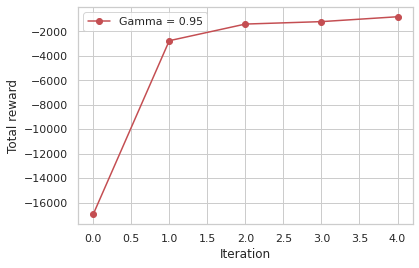

In [0]:
with open (directory, "wb") as file:
  pickle.dump([total_reward_list, sc_price, sc_energy], file)

with open (directory, "rb") as file:
  result = pickle.load(file)
  total_reward_list = result[0]
  sc_price = result[1]
  sc_energy = result[2]
  
plt.plot(np.array(total_reward_list), 'r-o', label = "Gamma = 0.95")
plt.xlabel("Iteration")
plt.ylabel("Total reward")
plt.legend()
plt.show()

# **Result**

**Testing**

In [0]:
#drive.mount('/content/drive/')
DQN.model.load_weights(directory + ".hdf5")

SOC = np.array([battery.initial_SOC])
historical_price = np.zeros(timesteps)
day = 0
hour = 0
timestep = 0
done = False
SOC_list = []
fault_list = []
action_list = []
reward_list = []
av_price_list = []

while day < len(x) / 24:
  
  historical_price[timestep] = x[day * 24 + hour, 2]
  average_price = np.mean(np.array([price for price in historical_price if price != 0]))
  
  state = np.concatenate((x[day * 24 + hour, :], SOC, np.array([average_price])), axis = -1)
  action = np.argmax(DQN.model.predict(np.expand_dims(state, axis = 0)))
  
  next_SOC, reward = battery.compute(state, action)

  if battery.action_set[action] > 0:
    if battery.action_set[action] * battery.P_rated / battery.E_rated + SOC > 1:
      fault_list.append(1)
    else:
      fault_list.append(0)
  else:
    if battery.action_set[action] * battery.P_rated / battery.E_rated + SOC < 0:
      fault_list.append(1)
    else:
      fault_list.append(0) 
  
  SOC = next_SOC
  SOC_list.append(SOC)
  reward_list.append(reward)
  action_list.append(action)
  av_price_list.append(average_price)  
  
  if hour < 23:
    hour += 1
    timestep += 1
    if timestep >= timesteps:
      timestep = 0    
    historical_price[timestep] = x[day * 24 + hour, 2]
    average_price = np.mean(np.array([price for price in historical_price if price != 0]))
    next_state = np.concatenate((x[day * 24 + hour, :], next_SOC, np.array([average_price])), axis = -1)
  else:
    done = True
    day += 1
    hour = 0
    timestep += 1
    if timestep >= timesteps:
      timestep = 0
    if day < len(x) / 24:
      historical_price[timestep] = x[day * 24 + hour, 2]
      average_price = np.mean(np.array([price for price in historical_price if price != 0]))
      next_state = np.concatenate((x[day * 24 + hour, :], next_SOC, np.array([average_price])), axis = -1)
    else:
      break

In [0]:
print ("The mean of the reward received across the training set: {:.2f}".format(np.mean(reward_list)))  
print ("The number of faulty decision across the training set: {:.2f}".format(sum(np.array(fault_list))))  

The mean of the reward received across the training set: -0.01
The number of faulty decision across the training set: 4.00


In [0]:
def get_resultplot(SOC_list, av_price_list, x, start_idx, end_idx):
  hours = end_idx - start_idx
  if hours == 24:
    plt.figure(figsize = (8,7))
    plt.xticks(range(0, 24), range(1, 25))
  else:
    plt.figure(figsize = (25,5))
    plt.xticks(range(0, end_idx-start_idx, 24), range(1, end_idx-start_idx+1, 24))
  plt.step(range(0, hours), SOC_list[start_idx:end_idx], "ro-", label = "SOC")
  plt.step(range(0, hours), av_price_list[start_idx:end_idx], label = "avg price")
  plt.step(range(0, hours), x[start_idx:end_idx, 2], "bs-", label = "price")
  plt.step(range(0, hours), x[start_idx:end_idx, 0], "g*-", label = "pv")
  plt.step(range(0, hours), x[start_idx:end_idx, 1], "m--", label = "load")
  plt.bar(range(0, hours), battery.action_set[action_list[start_idx:end_idx]], 
          facecolor = "w", edgecolor = "k", label = "action")
  plt.ylabel("SOC/ Normalized Price")
  plt.xlabel("Hour")
  plt.legend(loc=2)
  plt.show()  

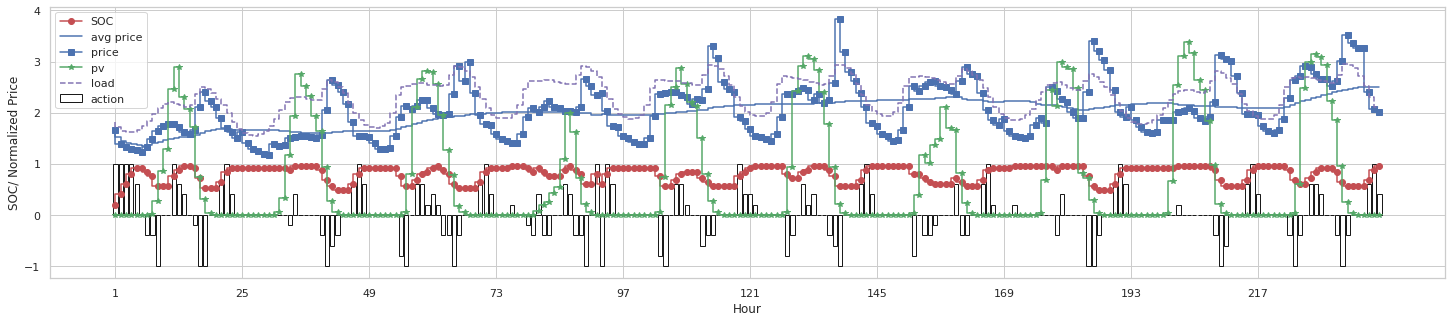

In [0]:
# First 10 days
start_idx = 0
end_idx = 240
get_resultplot(SOC_list, av_price_list, x, start_idx, end_idx)

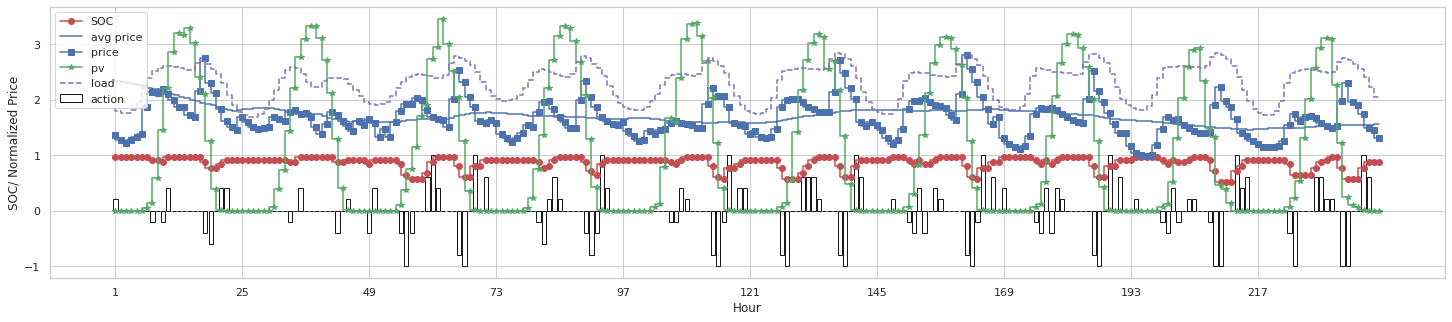

In [0]:
# Second last ten days
start_idx = -480
end_idx = -240
get_resultplot(SOC_list, av_price_list, x, start_idx, end_idx)

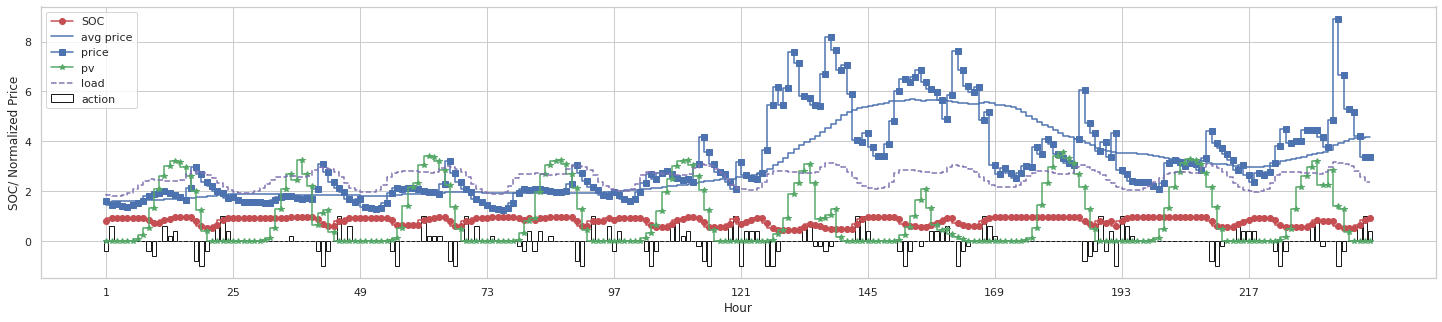

In [0]:
# Second last ten days
start_idx = len(SOC_list) - 240
end_idx = len(SOC_list)
get_resultplot(SOC_list, av_price_list, x, start_idx, end_idx)

In [0]:
SOC_bef_list = SOC_list.copy()
SOC_bef_list.insert(0, 0)
SOC_bef_list = SOC_bef_list[0:-1]

TRC_WOESS = 0
TRC_WESS = 0
OC_WESS = 0

for i in range(0, len(x), 1):
  
  # Without ESS  
  TRC_WOESS = TRC_WOESS - sc_price.inverse_transform(x[i:i+1, 2:3]) / 100 \
              * sc_energy.inverse_transform(x[i:i+1, 1:2] - x[i:i+1, 0:1])
  TC_WOESS = TRC_WOESS  
  
  # With ESS
  TRC_WESS = TRC_WESS - sc_price.inverse_transform(x[i:i+1, 2:3]) / 100\
             * sc_energy.inverse_transform(x[i:i+1, 1:2] - x[i:i+1, 0:1] \
             + np.expand_dims((np.array(SOC_list[i]) - np.array(SOC_bef_list[i])) * battery.P_rated, axis = -1))
  OC_WESS = OC_WESS - sc_price.inverse_transform(battery.wear_cost) \
             * sc_energy.inverse_transform(np.abs(np.expand_dims((np.array(SOC_list[i]) - np.array(SOC_bef_list[i])) * battery.P_rated, axis = -1)))
  TC_WESS = TRC_WESS + OC_WESS

print ("Cost without ESS: {:0.2f}".format(np.sum(TC_WOESS)))
print ("Cost with ESS: {:0.2f}".format(np.sum(TC_WESS)))
print ("Net benefit: {:0.2f}".format(np.sum(TC_WESS - TC_WOESS)))
print ("Daily mean cost without ESS: {:0.2f}".format(np.sum(TC_WOESS / (len(x) / 24))))
print ("Daily mean cost with ESS: {:0.2f}".format(np.sum(TC_WESS / (len(x) / 24))))
print ("Daily net benefit: {:0.2f}".format(np.sum(TC_WESS - TC_WOESS) / (len(x) / 24)))

Cost without ESS: -29364932.48
Cost with ESS: -29340342.88
Net benefit: 24589.60
Daily mean cost without ESS: -27164.60
Daily mean cost with ESS: -27141.85
Daily net benefit: 22.75


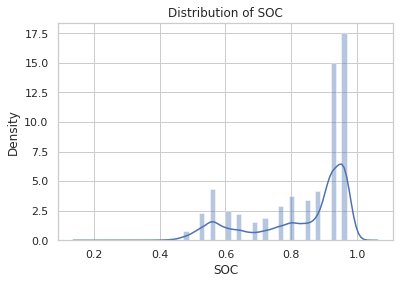

The probability of SOC smaller than target SOC is: 1.57%


In [0]:
sns.distplot(np.array(SOC_list), hist = True, norm_hist = True)
plt.ylabel("Density")
plt.xlabel("SOC")
plt.title("Distribution of SOC")
plt.show()

print("The probability of SOC smaller than target SOC is: {:.2f}%".format(np.sum(np.array(SOC_list) < 0.5) / len(SOC_list) * 100))

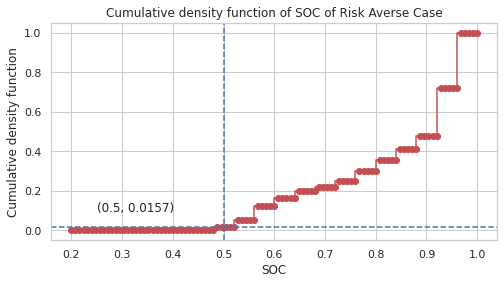

In [0]:
hist, bin_edges = np.histogram(np.array(SOC_list), bins = 100, density = True)
cum_prob = np.hstack((np.array([0]), np.cumsum(hist * np.diff(bin_edges)) / np.sum(hist * np.diff(bin_edges))))
target_SOC = battery.target_SOC
cum_prob_target = cum_prob[np.argmax(bin_edges >= target_SOC)]

plt.figure(figsize=(8, 4))
plt.step(bin_edges, cum_prob, "r-o")
plt.axvline(x  = target_SOC, linestyle = "--")
plt.axhline(y  = cum_prob_target, linestyle = "--")
plt.annotate("({}, {:.4f})".format(target_SOC, float(cum_prob_target)), 
             xy=(target_SOC - 0.25, cum_prob_target + 0.08))
plt.title("Cumulative density function of SOC of Risk Averse Case")
plt.xlabel("SOC")
plt.ylabel("Cumulative density function")
plt.show()

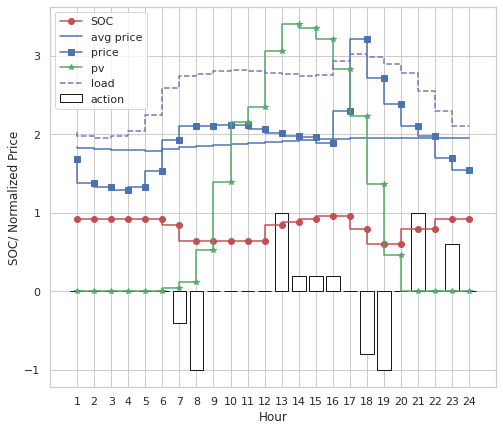

In [0]:
# Case 1 - Charged with PV not with grid to contain excess PV even the price is higher than average
# Use the spare capacity to store PV
# Not below the target SOC
start_idx = len(SOC_list) - 192
end_idx = len(SOC_list) - 168
get_resultplot(SOC_list, av_price_list, x, start_idx, end_idx)

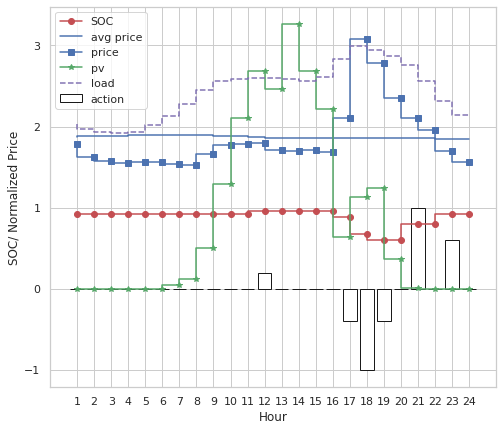

In [0]:
# Case 2 - Does not charge anymore when it is full
# When the price is not fluctuating
start_idx = len(SOC_list) - 216
end_idx = len(SOC_list) - 192
get_resultplot(SOC_list, av_price_list, x, start_idx, end_idx)

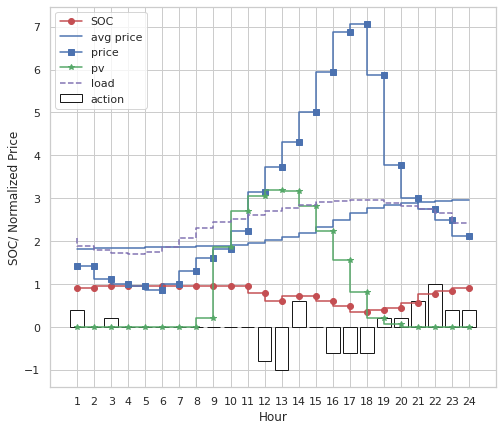

In [0]:
# Case 3 - Extremely high price
# Discharge even the pv is higher than local load
# Go below target SOC
start_idx = 13079
end_idx = 13103
get_resultplot(SOC_list, av_price_list, x, start_idx, end_idx)

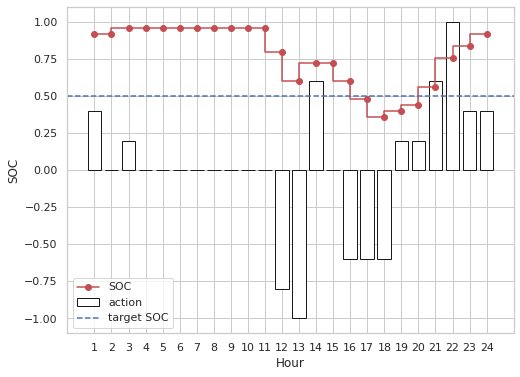

In [0]:
# Zoom of case 3

fig, ax = plt.subplots(1, 1, figsize = (8,6))
#ax2 = ax.twinx()
ln1 = ax.step(range(0, 24), SOC_list[13079:13103], "ro-", label = "SOC")
ln2 = ax.bar(range(0, 24), battery.action_set[action_list[13079:13103]], 
             facecolor = "w", edgecolor = "k", label = "action")
ln3 = ax.axhline(y  = 0.5, linestyle = "--", label = "target SOC")
ax.set_xlabel("Hour")
ax.set_ylabel("SOC")
lns = ln1 + [ln2] + [ln3]
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc = 3)
plt.xticks(range(0, 24), range(1, 25))
plt.show()